In [445]:
#Need intro and questions to be put here
# Dealer is giving  you a list of vehicles (Teslas? )
# Normally you'd sell at your store but due to Covid people do not want to enter your store
# One ofc your seller's suggest Craiglist and sys he's willing to sell the vehicle on it
# We have seller who is willing to sell the vehicles for us on Craigslist should we take it?
#story boarding might give us more info

In [446]:
#Intro

In [447]:
#Problem

## Prepping the Data

Loading Software

In [448]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import urllib
import requests
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler



In [449]:
#Data in question (Auto Data)

Loading Data

In [450]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames

file = 'vehicles.csv'

print('If you are using the data in my github the data is actually already at the auto_data.csv stage renamed')
print('However all the code can be run except for one cell which is clearly marked')

sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)



#Open data
auto_data.head(5)

C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2backup.ipynb', 'auto_clean_copy3.ipynb', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_deletion.png', 'figures', 'Figx_ModelComparison.png', 'Figx_ModelComparison_Std.png', 'Figx_Model_Comparison_RMSLE.png', 'Figx_Model_Comparison_std.png', 'Scrap.ipynb']
If you are using the data in my github the data is actually already at the auto_data.csv stage renamed
However all the code can be run except for one cell which is clearly marked


KeyboardInterrupt: 

Exploratory Data1

In [ ]:
#Print the columns names of the entire dataframe
print(auto_data.columns)
# Review the column names, null value counts and data types of your data frame.
auto_data.info()


Variables drop
* url   - We will not be using urls in this study
* region_url   -  We will not be using urls in this study
* description   - Unique for each vehicle
* VIN   - Unique for each vehicle
* image_url - We will not be using urls in this study 
* county    - there is no non 0 data points there

Drop if data
* if condition is unknown from wreck to clean we don't need it
* if model year is unknown we do not know the age
* Odometer measures mileage, if we don't know the wear on the cars
* if we don't know the model car we don't know the car
* If we don't know the price we don't have the data we are predicting for


In [ ]:

auto_data= auto_data.drop(columns=['url', 'region_url', 'image_url', 'county', 'description', 'vin'])
print(auto_data.columns)
auto_data= auto_data.dropna(subset=['condition', 'year', 'odometer', 'model', 'price'])

#known main points for an auto sale condition, age, mileage, type of car if the cars don't have it we don't want it

### Transforming Rules: Common Sense

* Cylinders come in whole numbers for an engine (there is no quarter cylinder)
* Manufacturer names should be consistent

In [ ]:
#Turn Cylinder column from string to numeric
auto_data['cyl'] = auto_data['cylinders']
auto_data['cyl'] = auto_data['cyl'].replace('other', np.nan)
auto_data['cyl'] = auto_data['cyl'].astype(str).str[0:2]
auto_data['cyl'] = auto_data['cyl'].str.strip()
auto_data['cyl'] = auto_data['cyl'].replace('na', np.nan)
auto_data['cyl'] = pd.to_numeric(auto_data['cyl'])
auto_data['cylinders']= auto_data['cyl']
auto_data= auto_data.drop(['cyl'], axis=1)

#plot Cylinders
plt.title("Numerical Cylinders")
hist = auto_data.cylinders.hist(bins=10)

In [ ]:
#Neaten Strings
#Fix manufacturer
auto_data['manufacturer']= auto_data['manufacturer'].str.title().str.strip()
auto_data['manufacturer']= auto_data['manufacturer'].str.replace(' ', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Land-Rover', 'Rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Rover', 'Land-Rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Porche', 'Porsche')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('---', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('--', '-')


#Fix model
auto_data['model']= auto_data['model'].str.title().str.strip()
auto_data['model']= auto_data['model'].str.replace(' ', '-')
auto_data['model']= auto_data['model'].str.replace('---', '-')
auto_data['model']= auto_data['model'].str.replace('--', '-')

#fix Type
auto_data['type']= auto_data['type'].str.title().str.strip()

#States are state codes
auto_data['state'] = auto_data['state'].str.upper().str.strip()

#If no paint color is given its unlisted and its unrealistc to try to impute it
auto_data['paint_color'] = auto_data['paint_color'].fillna('unlisted')


In [ ]:
auto_data.info()

Cleaning Rules: Common Sense

* This study is not looking at over luxury cars/ antique cars  so 
    * None of the vehicles should have a price greater than half a million
* This study is not looking at motorbikes or bus's 
    * we don't need harley davidson's or henessey's 
    *
* This study is not looking at junker cars so we do not need vehicles 
    * of a value of a 100 dollars or less
    * with over a half milion miles on them
    * are of poor condition
    * older than 10 years old (we are also not looking at antique cars
    * that has a condition/title status is better than salvage 
* Cleaning Obvious errors:
    * We are looking at used vehicles so the vehicles age should be greater than 1 year
* We do not need to take into consideration vehicles older than 10 years old. 




In [ ]:
# If we are dealing with a vehicle with over a half milion miles we have more problem
auto_data = auto_data[(auto_data.odometer< 500000)] 


#This study is not look at eather junkers or antiques so 
#a: age has to be greater than 0 and less than 11 years
#b: price has to be greater than $100 and less than half million
#c: mileage has to be greater than or equal to 0 and less than half million

auto_data['age'] = 2020-auto_data['year']
auto_data = auto_data[(auto_data.age > 0) & (auto_data.age <= 10)]
auto_data = auto_data[(auto_data.price >= 100) & (auto_data.price <= 500000)]
auto_data = auto_data[(auto_data.odometer >= 0) & (auto_data.odometer <= 500000)]


print(f"Maximum price: $ {auto_data.price.max()} \nMinimum price: $ {auto_data.price.min()} ")
print(f"Maximum age:  {auto_data.age.max()} years \nMinimum age: {auto_data.age.min()} years ")
print(f"Maximum mileage: {auto_data.odometer.max()} \nMinimum mileage: {auto_data.odometer.min()} ")


In [ ]:
#This study is not look junkers so condition and title_ status is better than salvage

#See Status of Vehicles
auto_data.title_status.value_counts().plot.bar()
plt.title("Status of the vehicles")
plt.show()


In [ ]:
#See Condition of Vehicles

auto_data.condition.value_counts().plot.bar()
plt.title("Condition of the vehicles")
plt.show()

In [ ]:
#This study does not look junkers so condition and title_ status is better than salvage

idx1 = auto_data[auto_data["condition"] == "salvage"].index

for w in ["salvage","lien","missing","parts only", 'rebuilt']:
    idx2 = auto_data[auto_data["title_status"] == w].index
    idx1 = idx1.union(idx2)
    
auto_data.drop(idx1, axis = 0, inplace = True)

In [ ]:
#We are not looking at motorbikes

#Graph manufacturers

auto_data.manufacturer.value_counts().plot.bar()
plt.title("manufacturer of the vehicles")
plt.show()

In [ ]:

#We are not looking at motorbikes
auto_data = auto_data[auto_data.manufacturer != 'Harley-Davidson']
auto_data = auto_data[auto_data.manufacturer != 'Hennessey']

In [ ]:
#We are not looking at buses
#Graph type

auto_data.type.value_counts().plot.bar()
plt.title("type")
plt.show()

In [ ]:
#We are not looking at bus
auto_data = auto_data[auto_data.type != 'bus']


In [ ]:
#Create Make Model Model Year Key (Useful for later)
auto_data['mmy_a']=auto_data['manufacturer']+' '+auto_data['model']+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a']=auto_data['mmy_a'].str.title()

auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model'].str.split(' ').str[0]+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a2']=auto_data['mmy_a2'].str.title()


In [ ]:
auto_data.info()

In [ ]:
auto_data.describe()

Save Data

In [ ]:
sub_file = 'data'
new_file = 'auto_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data.to_csv(new_file_name_path, index=False)

## Categorical Data
We want data on what segment the vehicle is in as that might change the prices signicantly.
We got this data from back4app an open data source.
Website: https://www.back4app.com/database/back4app/car-make-model-dataset

In [ ]:
#Get Categorical Data

where = urllib.parse.quote_plus("""
{
    "Category": {
        "$exists": true
    },
    "Year": {
        "$gte": 2010
    }
}
""")
url = 'https://parseapi.back4app.com/classes/Carmodels_Car_Model_List?limit=5000&where=%s' % where
headers = {
    'X-Parse-Application-Id': 'pozCwVISt2yfzi2wJjwo0JiMIJclsUAOchP4AuJO', # This is your app's application id
    'X-Parse-REST-API-Key': 'Jtc8r91VIJOizG8ReKkaseZcugQjAx4vG1WKbJye' # This is your app's REST API key
}
data_json = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need


#import collections

In [ ]:
#the above data was too nested a dictionaries listed in a list that was in a list that was a dictionary
print(type(data_json))
list_values = [ v for v in data_json.values() ] #undoes dictionary

list_value_items = [y for x in list_values for y in x] # undoes list

cat_data = pd.DataFrame.from_dict(list_value_items) #turns list of dictionaries into data frame


In [ ]:
#we don't need object id or created at
cat_data= cat_data.drop(['objectId', 'createdAt'], axis=1)
print(cat_data.head())
cat_data.describe()

In [ ]:
#Neaten Strings
cat_data['Make'] = cat_data['Make'].str.title().str.strip()
cat_data['Make']= cat_data['Make'].str.replace(' ', '-') 
cat_data['Model'] = cat_data['Model'].str.title().str.strip()
cat_data['Model']= cat_data['Model'].str.replace(' ', '-') 

#Create Key
cat_data['mmy']=cat_data['Make']+' '+cat_data['Model'].str.strip()+ ' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy']= cat_data['mmy'].str.title()

cat_data['mmy2']=cat_data['Make']+' '+cat_data['Model'].str.split(' ').str[0]+' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy2']= cat_data['mmy2'].str.title()



In [ ]:
cat_data.info()

In [ ]:

#Save Categorical Data
sub_file = 'data'
new_file = 'cat_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
cat_data.to_csv(new_file_name_path, index=False)

## Find MSRP data
The original price of the car will heavily effect the older price. Let's bring that out.
This data is a downloaded file from https://www.kaggle.com/CooperUnion/cardataset . This data was obtained by scraping edmunds (a car rating website) and twitter.

In [ ]:
# Create the list of file names: filenames
file ='msrp.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
msrp_data= pd.read_csv(file_name_path)

#Open data
msrp_data.head(5)

In [ ]:
#From the previous cleaning rules we eliminate vehicles with value of over half a million and an age over 10 years

print(f"Maximum MSRP: {msrp_data.MSRP.max()} \nMinimum MSRP: {msrp_data.MSRP.min()} ")
# If we are dealing with a vehicle with an MSRP over half milion miles we have more problem
msrp_data = msrp_data[(msrp_data.MSRP< 500000 )] 
print(f"Maximum Year: {msrp_data.Year.max()} \nMinimum Year: {msrp_data.Year.min()} ")
# We only need vehicles with over a 2009 MY
msrp_data = msrp_data[(msrp_data.Year> 2009 )] 



In [ ]:
# Clean Strings/ Neaten Strings

msrp_data['Make']= msrp_data['Make'].str.title().str.strip()
msrp_data['Make']= msrp_data['Make'].str.replace(' ', '-')
msrp_data['Model']= msrp_data['Model'].str.title().str.strip()
msrp_data['Model']= msrp_data['Model'].str.replace(' ', '-')

#Make Keys
msrp_data['mmy']=msrp_data['Make']+' '+msrp_data['Model']+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy']= msrp_data['mmy'].str.title()
msrp_data['mmy2']=msrp_data['Make']+' '+msrp_data['Model'].str.split(' ').str[0]+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy2']= msrp_data['mmy2'].str.title()



In [ ]:
MSRP_dict = msrp_data.groupby(['Make', 'Model', 'Year', 'mmy', 'mmy2'])['MSRP'].mean().reset_index()

In [ ]:
MSRP_dict.info()

In [ ]:
sub_file = 'data'
new_file = 'msrp.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
msrp_data.to_csv(new_file_name_path, index=False)

# Merging Data

In [ ]:
## Merging Auto and MSRP

#Create Dictionaries to map with

First the MMY
* automobiles models are referenced by its a) manufacture b) model name, and C) model year (otherwise known as the MMY)
* Each mmy has an average MSRP to go with it and a specific groups of catehories can be in 
    * (ex a camry can be sedan or hatchback it can't be a pickup)
* We will therefore use the MMYas a key to map the MSRP and category to the main data set

Issue: Model names of automobile
* The trim of a model is referencing a set of additional features comes with (example Camry Lux has leather seats)
* The trim changes the price of a vehicle
* Therefore sometimes sellers will add the trim after the model design to give a better idea of what they are selling
* This leads to the model name not being consistent across tables.

Fixing the Issue
* To ensure better mapping we will therefore use 2 keys 
* The first key will match the full name of the model for the mmy
* The second key will match the first word name of the model for the mmy
* We will try to map to first the key if a map isn't reached we use the results from the second key.
* both keys include the manufacturer and model year



In [ ]:
#Create Dictionaries to map with


#create mmy key2 for autos
auto_data['model2']= auto_data['model'].str.split(' ').str[0]
auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model2']+ ' '+ auto_data['year'].astype(int).astype(str)

#auto_dictionary
auto_dict= auto_data[['manufacturer', 'model', 'year', 'mmy_a', 'mmy_a2']].drop_duplicates(keep='last')

#MSRP_dictionary_1 has only the first key
MSRP_dict1 = MSRP_dict[['mmy', 'MSRP']]

#MSRP_dictionary_2 has only the second key
MSRP_dict2= MSRP_dict[['mmy2', 'MSRP']]
MSRP_dict2['MSRP_vague'] = MSRP_dict2['MSRP']
MSRP_dict2= MSRP_dict2.drop(columns= ['MSRP'])



In [ ]:
#Merge auto_dict and MSRP dictionary 1 into df1 using the 1st key
df1= pd.merge(auto_dict, MSRP_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )
#Merge dictionary3 and MSRP dictionary 2 into auto_msrp_dictionary using the second key
a_m_dict= pd.merge(df1, MSRP_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#fill any null results in MSRP from first key map by results in second key
a_m_dict['MSRP']=a_m_dict['MSRP'].fillna(a_m_dict['MSRP_vague']) 

#drop duplicates
a_m_dict= a_m_dict[['mmy_a', 'mmy', 'mmy2','MSRP']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [ ]:
#Cat_dictionary_1 has only the first key
cat_dict= cat_data[['Make', 'Model', 'Year', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['Make', 'Model', 'Year', 'mmy', 'mmy2'], keep='last')
cat_dict1 = cat_dict[['mmy', 'Category']]


#Cat_dictionary_2 has only the second key
cat_dict2= cat_dict[['mmy2', 'Category']]
cat_dict2['Category_vague'] = cat_dict2['Category']
cat_dict2= cat_dict2.drop(columns= ['Category'])


In [ ]:
#Merge auto dictionary and cat dictionary 1 into dictionary into df1 using the first key
df1= pd.merge(auto_dict, cat_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )

#Merge dictionary3 and cat dictionary 2 into auto_cat_dictionary using the second key
a_c_dict= pd.merge(df1, cat_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#Fill in blanks in the Category left from the first key with results from the second key (if any)
a_c_dict['Category']=a_c_dict['Category'].fillna(a_c_dict['Category_vague']) 


#drop duplicates 
a_c_dict= a_c_dict[['mmy_a', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [ ]:
print(a_c_dict.info())
print(a_m_dict.info())

In [ ]:
#Merge Cat and MSRP
#We still have two keys mmy_a and mmy

a_m_dict_1= a_m_dict[['mmy_a', 'MSRP']].dropna()
a_m_dict_2= a_m_dict[['mmy', 'MSRP']].dropna()
a_m_dict_3= a_m_dict[['mmy2', 'MSRP']].dropna()

a_m_dict_2= a_m_dict_2.rename(columns={"MSRP": "MSRP_2"})
a_m_dict_3= a_m_dict_3.rename(columns={"MSRP": "MSRP_3"})


In [ ]:
#Merge a_c and a_m dict on first key
df1= pd.merge(a_c_dict, a_m_dict_1, on='mmy_a', how='outer')


In [ ]:
#Merge a_c and a_m dict on second key
df2 = pd.merge(df1,  a_m_dict_2, left_on='mmy', right_on='mmy', how='outer' )


In [ ]:
#Merge a_c and a_m dict on third key
a_m_c_dict = pd.merge(df2,  a_m_dict_3, on='mmy2', how='outer' )
a_m_c_dict.info()



In [ ]:
#Fill in blanks in the MSRP left from 1st key with results from the 2nd and 3rd key (if any)
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_2']) 
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_3']) 

#drop duplicates
a_m_c_dict= a_m_c_dict[['mmy_a', 'MSRP', 'Category']].drop_duplicates(subset=['mmy_a'], keep= 'last' )

#drop if missing 'mmy_a'
a_m_c_dict = a_m_c_dict[a_m_c_dict['mmy_a'].notna()]


Merge Dictionaries with auto

In [ ]:
z= pd.merge(auto_data, a_m_c_dict, on='mmy_a', how='left')
z.info()
auto_data= z

###  Find State data
We can use geographic data to find other data we need. Two things that common wisdom suggests effect car prices 
1) Amount of money people make 
2) gas prices 
We can find the average income people make in the state as well as the aproximate gas prices when this Craigslist dataset was collected.

Gas prices come from AAA which shows the daily average gas prices for a state. They do not store this data so the data was scraped from the next nearest date available from the scraping of the Craiglist data which was Feb 22 https://web.archive.org/web/20200226222808/https://gasprices.aaa.com/state-gas-price-averages/
This data for household income was from https://dqydj.com/average-income-by-state-median-top-percentiles/ a place that holds financial data and that is recommend by the WSJ and the NYT. This has already been done


## Add State Data

In [ ]:


#get_state_data
state_file ='state_data.csv'

print('p')
file_name_path = os.path.join(basepath, 'data', state_file)
state_data= pd.read_csv(file_name_path)
state_data.info()
#Open data


In [ ]:
#merge_with_state_data
auto_data_m= auto_data.merge(state_data, left_on='state', right_on='State_Code')
auto_data_m.info()
auto_data = auto_data_m

In [ ]:
#save data

new_file = 'auto_data_m_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data_m.to_csv(new_file_name_path, index=False)

## Impute the Data

When looking at the vehicles we note that there are lot of nulls about the vehicles features (example: the number of cylinders, drive, transmission, size, and type of vehicle). When buying a vehicle these are things you would usually ask the seller because it does effect the price of the vehicle (a vehicle with more cylinders usually is of higher value than one is of less). 

While these features can differ within a make model model year (MMY) of a vehicle we can narrow down what the feature should be given the other features of the vehicle. For example: a 2016 Jaguar F Type can be all wheel drive or all-wheel drive ,  be a coupe or convertible, be automatic or manual transmission. You would think there be at least 8 configurations of the F-type.   However only a certain grouping of configurations (called Trims) that these vehicle are sold as.  There are actually on 6 configurations for the 2016 Jaguar F-Type because you can only get a manual transmission with rear wheel drive. 

If we don't have enough data to impute the vehicle given MMY and the other features we can determine the feature given it's MMY. This is because A) There is usually a most popular trim for the MMY of a vehicle. B) Some features do not differ within MMY for example the 2017 Honda Accord only has 4 cylinders. 


If make model model year does not give us a value we can look at just the make and model. The most likely configuration for model does change for each model year. However the trims of these features only change for every redesign of the model which does not happen every model year. So after looking at mmy we look at make model.


Finally we are also missing longitude and latitude data. We can find the probable longitude and latitude given the most longitude and latitude for that state.


In [ ]:
file = 'auto_data_m_cl.csv'

sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


In [ ]:
auto_data['type']= auto_data['type'].str.title().str.strip()

auto_data['type'].value_counts()

In [ ]:
auto_data.isnull().sum()

In [ ]:
auto_data['cylinders'] = pd.to_numeric(auto_data['cylinders'])

q1 = auto_data
#Create possible Trim configurations look at cylinders, drive and transmission
q1['mmy_a_d_t'] = q1['mmy_a'].astype(str)+' '+q1['drive'].astype(str)+' '+q1['transmission'].astype(str)
q1['mmy_a_t'] = q1['mmy_a'].astype(str)+' '+q1['transmission'].astype(str)
q1['mmy_a_d'] = q1['mmy_a'].astype(str)+' '+q1['drive'].astype(str)

#Remove trim if there is missing value in the grouping
q1.loc[(q1['transmission'].isna()), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['transmission'].isna()), 'mmy_a_t' ] = np.nan
q1.loc[(q1['transmission'].str.contains('nan', na= False)), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['transmission'].str.contains('nan', na= False)), 'mmy_a_t' ] = np.nan
q1.loc[(q1['drive'].isna()), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['drive'].isna()), 'mmy_a_d' ] = np.nan
q1.loc[(q1['drive'].str.contains('nan', na= False)), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['drive'].str.contains('nan', na= False)), 'mmy_a_d' ] = np.nan

#Create Make Model Category
q1['mm']=q1['manufacturer'].astype(str)+' '+q1['model'].astype(str)
q1['mm2']=q1['manufacturer'].astype(str)+' '+q1['model2'].astype(str)


In [ ]:
def comp_F(q1):
    q1['cylinders1'] = q1['cylinders']
    q1['size1'] = q1['size']
    q1['Category1'] = q1['Category']
    q1['type1'] = q1['type']
    q1['drive1'] = q1['drive']
    q1['transmission1'] = q1['transmission']
    
def comp_D(q1):
    q1['cylinders'] = q1['cylinders'].fillna(q1['cylinders1'])
    q1['size'] = q1['size'].fillna(q1['size1'])
    q1['Category'] = q1['Category'].fillna(q1['Category1'])
    q1['type'] = q1['type'].fillna(q1['type1'])
    q1['drive'] = q1['drive'].fillna(q1['drive1'])
    q1['transmission1'] = q1['transmission'].fillna(q1['transmission1'])

print(q1['cylinders'].isnull().sum())
print(q1['cylinders'].value_counts())
q1['cylinders1'] = q1['cylinders']
q1['cylinders1'] = q1.groupby(['mmy_a_d_t', 'type'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['cylinders'] = q1['cylinders'].fillna(q1['cylinders1'])


print(q1['cylinders'].isnull().sum())
print(q1['cylinders'].value_counts())

In [ ]:
print(q1['cylinders'].value_counts())
comp_F(q1)
q1['cylinders1'] = q1.groupby(['mmy_a_d_t', 'type'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
comp_D(q1)
q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum()
print(q1['cylinders'].value_counts())

In [ ]:
q1['cylinders'].value_counts()

In [ ]:
#impute by trim
comp_F(q1)
q1['MSRP1'] = q1['MSRP']

print('Before imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


q1['MSRP'] = q1.groupby(['mmy_a_d_t', 'type'], sort=False)['MSRP'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['cylinders1'] = q1.groupby(['mmy_a_d_t'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mmy_a_d_t'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mmy_a_d_t'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mmy_a_d_t'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mmy_a_t'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mmy_a_d'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

q1['MSRP'] = q1['MSRP'].fillna(q1['MSRP1'])
comp_D(q1)

print('After trim imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())



In [ ]:
#impute by Make Model Model Year
comp_F(q1)
cols = ['cylinders1', 'size1', 'Category1', 'type1', 'drive1', 'transmission1']

q1['cylinders1'] = q1.groupby(['mmy_a'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mmy_a'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mmy_a'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mmy_a'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mmy_a'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mmy_a'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))


comp_D(q1)
print('After manufacture model and model year  imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


In [ ]:
#impute by Make Model
comp_F(q1)
q1['cylinders1'] = q1.groupby(['mm'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mm'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mm'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mm'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mm'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mm'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
comp_D(q1)
print('After manufacture model and model year  imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


In [ ]:
q1.info()

In [ ]:
#Drop Excess Variables that were used for imputation
q1 = q1.drop(columns=['cylinders1', 'size1','Category1','type1' , 'drive1', 'transmission1', 'MSRP1'], axis=1 )
q1 = q1.drop(columns=['mmy_a', 'mmy_a2','mmy_a_d_t','mmy_a_d' , 'mmy_a_t', 'mm', 'mm2', 'model2'], axis=1 )

In [ ]:
#impute longitude and latitude from state
q1['lat'] = q1.groupby(['state'], sort=False)['lat'].apply(lambda x: x.fillna(x.mode().iloc[0]))
q1['long'] = q1.groupby(['state'], sort=False)['long'].apply(lambda x: x.fillna(x.mode().iloc[0]))

#impute fuel
q1['fuel'] = q1['fuel'].fillna(q1['fuel'].mode()[0])
q1['MSRP'] = q1['MSRP'].fillna(0)
print(q1.isnull().sum())

In [ ]:
#If no paint color is given its unlisted and its unrealistc to try to impute it
q1['paint_color'] = q1['paint_color'].fillna('unlisted')

In [ ]:
q1['Avg_Mileage'] = q1['odometer']/ q1['age']
q1['resid'] = q1['MSRP']/ q1['price']
q1.info()

In [ ]:

categorical_columns = q1.select_dtypes(exclude=['int64', 'float']).columns.tolist()

for col in categorical_columns:
    q1[col] = q1[col].astype('category')
q1.info()

Save Data

In [ ]:
#save data

new_file = 'auto_data_merged_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
q1.to_csv(new_file_name_path, index=False)

## Exploratory Data getting rid of outliers

We do not want any outliers in our dataset before we make any calculations. That said:
1) We already eliminated a lot of the ouliers due to the common sense cleaning rules.
2) The values for price, and mileage in the vehicle is a skew distribution with a long tail and not a normal distribution.

Therefore we are conservative in our deletion of outliers.

We beleive we should investigate four outliers when:
* The 98the percentile and the 99th percentile differ by larger than 1 standard deviation. Then all values greater than the 98th percentile are likely to be outliers.
* Similarly elimiate if 99th percentile and maximum differ by larger than 1 standard deviation. Then all values greater than the 99th percentile are likely to be outliers.

The results of this investigation is that price, odometer, residual and average mileage needed to be investigaated.

We did not want to get rid of any vehicles that are in the same price range of the Teslas so we eliminated vehicles


In [ ]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_merged_cl.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


In [ ]:
auto_data.info()

In [ ]:
auto_data['resid'] = auto_data['resid'].fillna(0)
auto_data.describe(percentiles= [0.05, .25, .5, .75, 0.95,  0.98, 0.99, 0.999] )
# Rule if the maximum number of the 98the percentile and the 99th percentile differ by larger than 1 std then you elimate those numbers
# Similarly elimiate if 99th percentile and maximum is one standard deviation away elimate to 99th percentile


* Rule if the maximum number of the 98, 99 percentile differ by larger than 1 std you investigate
    * The results of this investigation is in price, odometer and average mileage
* Similarly we check if adding 98 percentile + 1std is worth doing



In [ ]:
#Investigate price 
price = auto_data.price
sns.boxplot(price)
plt.savefig("Fig1_Price_before_deletion.png")
plt.title("Distribution of the price before deletion")
plt.show()
#so many outliers!

In [ ]:
#We do not want to get rid of any vehicles that are in the same price range of the Teslas so we eliminated 
#vehicles under the maximum Tesla price


tes = auto_data[auto_data.manufacturer == 'Tesla']
Tes_price = tes['price'].max()
auto_data= auto_data[auto_data.price< Tes_price ]
price = auto_data.price
sns.boxplot(price)
plt.title("Distribution of the price after deletion")
plt.savefig("Fig2_Price_after_deletion.png")
plt.show()


In [ ]:
#Investigate Mileage
miles = auto_data.odometer
sns.boxplot(miles)
plt.title("Distribution of mileage on vehicles before deletion")
plt.show()
#so many outliers!

In [ ]:
#We eliminate vehicles over the 98th percentile
odometer_p98 = auto_data['odometer'].quantile(.98)

auto_data= auto_data[auto_data.odometer< odometer_p98 ]
miles = auto_data.odometer
sns.boxplot(miles)
plt.title("Distribution of mileage on vehicles after deletion")
plt.show()

In [ ]:
#Investigate Average Mileage
# Average Milage is the mileage divided by the age let's see that relationship 
g = sns.jointplot(x= 'age', y='odometer',data=auto_data , kind='kde')
_ = g.title = 'Age vs Mileage'
#We van see clustered Non Linear replationsip between age and mileage and some pretty clear boundries

In [ ]:
#Investigate Average Mileage using boxplot
avg_miles = auto_data.Avg_Mileage
sns.boxplot(avg_miles)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
#so many outliers!

In [ ]:
#We eliminate vehicles over the 99th percentile
avm_p99 = auto_data['Avg_Mileage'].quantile(.99)

auto_data= auto_data[auto_data.Avg_Mileage< avm_p99]
avg_miles = auto_data.Avg_Mileage
sns.boxplot(avg_miles)
plt.title("Distribution of avg mileage per year on vehicles after deletion")
plt.show()
plt.show()

We Eliminate the Superluxury Vehicles

In [ ]:
#We are not loooking up superluxury cars aka
auto_data= auto_data[auto_data.manufacturer != 'Ferrari']
auto_data = auto_data[auto_data.manufacturer != 'Aston-Martin']

## EDA Explain some of the relationships within the data

In [ ]:
auto_data.cylinders.value_counts()

In [ ]:
#Check Cylinders
#Investigate cylinders
auto_data['cylinders'] = pd.to_numeric(auto_data['cylinders'])
cylinders = auto_data.cylinders
sns.boxplot(cylinders)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
cylinders.value_counts()
#We eliminate 12 as it only has 8 values 
auto_data =  auto_data[auto_data['cylinders']<12]


In [ ]:
#There is an interesting relationship between cylinders, and drive
size_type_table = pd.crosstab(index=auto_data["drive"], columns=auto_data["cylinders"])
plt.figure(figsize=(14,12))
size_type_table.plot(kind="bar",  figsize=(8,8), stacked=True)
plt.show()
plt.savefig("cylinder_drive.png")


In [ ]:
#There is an interesting relationship between cylinders, drive, mileage and price
plt.figure(figsize=(14,12))
sns.catplot(x="cylinders", y="price", hue='drive', kind='point', data=auto_data)
plt.show()
plt.savefig("cylinder_drive_mileage_price.png")


In [ ]:
g = sns.lmplot(x= 'odometer', y='price', data=auto_data,  col="cylinders", hue='drive', col_wrap=3, scatter_kws={"alpha":.6, "s": 5})
g = (g.set( ylim=(0, 100000)))

In [ ]:
# More visuals regarding the distributions are in eda3

## Cleaning Category/ type
* Category refers to the type of design of the vehicle ( examplesedan, hatchback), and it is something people take into consideration while buying a vehicle
* However the naming convention for this is non standard across manufactuers ("pickup" vs "truck" refers to the same type from Ford and GM respectively)
* Considering there are many users on Craigslist even though type is often in the description of a vehicle sold the naming convention would not be consistent from one user description to the next. 
* Since Category type is scraped from the user description means that type is inconsistent across the database

* A Singular third party from an automible expert in this case the USA government will give us a consistent naming convention across all vehicles
* However the goverment gives us a group of possible types a vehicle could be given make model model year

* By combining the user description and the third party categories we get a specific category for each vehicle which has a conistent naming convention across vehicles

* For the merge's we have we are going to check if the category within the description matches what the third party gave


In [ ]:
auto_data['type'].value_counts()

In [ ]:
auto_data['Category'].value_counts()

In [ ]:
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]
auto_data['Category3']= auto_data['Category'].str.strip().str.split(', ')
auto_data['Category3']= auto_data['Category3'].str.len()
auto_data['type'] = auto_data['type'].replace('Truck', 'Pickup')
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]
auto_data['type2']= auto_data['type'].replace('Offroad', np.nan)
auto_data['type2']= auto_data['type2'].replace('Other', np.nan)
auto_data['type2'] = auto_data['type2'].replace('Mini-Van', 'Van')
auto_data['type2'] = auto_data['type2'].replace('Van', 'Van/Minivan')
auto_data['Categoryf']= auto_data['Category'].fillna('0')
auto_data['typef']= auto_data['type2'].fillna('zzzz')
auto_data['Category_Cleaned1']= np.nan

In [ ]:
auto_data['typef'].value_counts()

In [ ]:
#If category length = 1 we do not need to look any further
auto_data['Category_Cleaned'] = np.where(auto_data['Category3'] == 1 , auto_data['Category'], np.nan)
print(auto_data['Category_Cleaned'].isnull().sum())

#check if vehicle type listed in description is the sameone that is in the data replace in that case
auto_data['cat_tiki_check0']= auto_data.apply(lambda x: x.typef in x.Categoryf, axis=1)
auto_data.loc[auto_data['cat_tiki_check0'] == True, 'Category_Cleaned1'] = auto_data.type
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['Category_Cleaned1'])

#If we can't specify through type and there are only two values listed in Category we pick the first
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['Category2'])


#If we can't specify through type and there more than two values listed in Category we use a cleaned version of type
auto_data['type2']= auto_data['type'].replace('Offroad', np.nan)
auto_data['type2']= auto_data['type2'].replace('Other', np.nan)
auto_data['type2'] = auto_data['type2'].replace('Mini-Van', 'Van')
auto_data['type2'] = auto_data['type2'].replace('Van', 'Van/Minivan')

auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['type2'])
print(auto_data['Category_Cleaned'].isnull().sum())

#If we can't specify through any of the above we call it unlisted
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna('Unlisted')


In [ ]:
auto_data.columns

In [ ]:

auto_data =auto_data.drop(columns = ['Category2', 'type2', 'Category3', 'Categoryf', 'typef', 'cat_tiki_check0', 'Category_Cleaned1'] )


## Feature Selection: Dropping Categorical Variables
* We want to reduce the number of unnecessary variables. Bellow are some of the reasons:
* We Eliminate categorical variables that are included in another variable (aka intercorrelation)
    * Example Division, State, and region. As each state has only one division. Each region can only fit in one states
    * We eliminated type and Category as they both fit within Category_cleaned
* We Eliminate categorical variables that are either unique to each vehicle (not counding id) or have too many categories within it because that would create too many dummy variables 
    * There are over 10000 models and while models are not completely unique to each vehicle considering we are trying to determine the asking price when we don't know the value of the model it goes around the point of the study. However again it could be something to look into.
    * There are over 400 regions while this could be an interesting study we don't need it as we have division, longitude and latitude. It might be something to look into for another study
    * There are over 50 states while this could be an interesting study we don't need it as we have division, longitude and latitude. It might be something to look into for another study.
* We eliminate variables that have only one value as the don't add anything to the model
    * title status

In [ ]:
auto_data.select_dtypes(exclude=['int64', 'float']).nunique()

In [ ]:
#drop categorical variables unique to each entry and/or having over 100 categories within
z2 =auto_data.drop(columns= ['model' ], axis=1)

#drop state due to combo of intercorrelation 
z2 =z2.drop(columns= ['region', 'state', 'type', 'Category', 'State_Code', 'State '], axis=1)

#drop to having only 1 value
z2 =z2.drop(columns= ['title_status'], axis=1)

z2 =z2.drop(columns= ['resid'], axis=1)

In [ ]:
z2['size']= z2['size'].fillna('unlisted')

In [ ]:
#Dropping Nulls- We prefer our data to be without nulls with the exception of MSRP and resid there are few nulls so we eliminate those

z2= z2.dropna()


## Feature Selection: Dropping Categorical Variables
### Eliminate variables due to intercorrelation

We check correlation between our features. We do not want highly correlated variables (aka correlation whose absolute value is of over 0.8 in our data). In our investigation we only find year which is highly correlated to age. We therefore eliminated year from our variables.

In [ ]:
#plot correlation
plt.figure(figsize=(14,12))
sns.heatmap(z2.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

In [ ]:
#dropping year- highly correlated with age amd c
z2= z2.drop(columns= ['year'])

## Pre Processing the Data

Befeore we can use the data to generate a model we need to make the data able to be understood by the model. In this case we scale the data and turn all our categorical variables into dummy variables. We then seperate the data into our training data and test data.


## Chosing Scaler Standardization

#### Standizing Data
* We have a few methods of standardization to choose from: Robust, Minmax, Normalize and Standardize
* We use Robust if we want to minimize impact of outliers
* We use Normalize if we think the distrubtion within a variable needs to be normalized and/or has a normal distribution
* We use Standardize when we think most of the variables have similar distribution and no/few dummy variables

In [ ]:

hist = z2.hist(figsize=(40,22))
#The data for price is and age are not a normal destribution so both normalize scaler is bad idea 

In [ ]:
z3 = z2.drop(columns=['id'])

boxplot = z3.boxplot(grid=False, vert=False,fontsize=9)
#No large outliers as that was cleaned out already earlier will not use Robust Scaler

In [ ]:
#save data

new_file = 'auto_data_cleaned.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
z3.to_csv(new_file_name_path, index=False)

#### Choosing Min Max Scaler
* The data for price is and age are not a normal destribution we eliminate normalize scaler
* No large outliers as that was cleaned out already earlier we eliminate  Robust Scaler
* As we have dummy variables we can eliminate standard scaler 
* That leaves us with Min Max scaler

## Create Dummy Variables

In [451]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_cleaned.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
z3 = pd.read_csv(file_name_path)
z3 = z3.reset_index()

C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2backup.ipynb', 'auto_clean_copy3.ipynb', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_deletion.png', 'figures', 'Figx_ModelComparison.png', 'Figx_ModelComparison_Std.png', 'Figx_Model_Comparison_RMSLE.png', 'Figx_Model_Comparison_std.png', 'Scrap.ipynb']


In [452]:
#shrink data where we can
categorical_columns = z3.select_dtypes(exclude=['int64', 'float']).columns.tolist()
for col in categorical_columns:
    z3[col] = z3[col].astype('category')
z3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114751 entries, 0 to 114750
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   index                    114751 non-null  int64   
 1   price                    114751 non-null  int64   
 2   manufacturer             114751 non-null  category
 3   condition                114751 non-null  category
 4   cylinders                114751 non-null  float64 
 5   fuel                     114751 non-null  category
 6   odometer                 114751 non-null  float64 
 7   transmission             114751 non-null  category
 8   drive                    114751 non-null  category
 9   size                     114751 non-null  category
 10  paint_color              114751 non-null  category
 11  lat                      114751 non-null  float64 
 12  long                     114751 non-null  float64 
 13  age                      114751 non-null  fl

In [453]:
#create dummy variables
Category_Cleaned = z3['Category_Cleaned']
auto_data_dummies= pd.get_dummies(z3) #changed from z2


In [454]:
new_file = 'auto_data_dummies.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data_dummies.to_csv(new_file_name_path, index=False)

In [455]:
df =auto_data_dummies.corr(method ='pearson')
df = df[((df > 0.7) | (df < -0.7)) & (df != 1)]
non_empty_cols = [col for col in df.columns if ~df[col].isnull().all()]
empty_cols = [col for col in df.columns if df[col].isnull().all()]

## Pre Processing Feature Selection: Dropping Dummy Variables
### Eliminate variables due to intercorrelation


1) Group Intercorrelation
When we have a categorical variables and convert them into dummies we can cannot have all the dummies in the group since  the last dummy variable will be a linear combination of the other dummies. So we eliminate one variable from the group.

2) Eliminate variables where absolute correlation is greater 0.8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114751 entries, 0 to 114750
Columns: 101 entries, index to Category_Cleaned_Wagon
dtypes: float64(9), int64(2), uint8(90)
memory usage: 19.5 MB


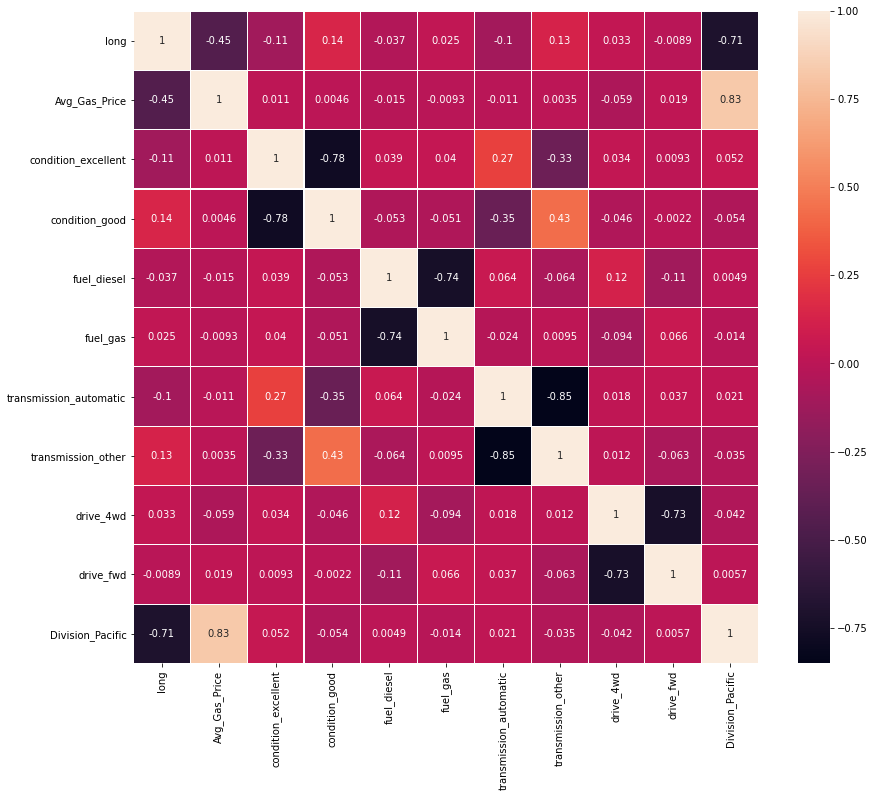

In [456]:
auto_data_dummies_small = auto_data_dummies.drop(columns= empty_cols)
plt.figure(figsize=(14,12))
sns.heatmap(auto_data_dummies_small.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

#Eliminate variables where absolute correlation is greater 0.8
auto_data_dummies.drop(columns= ['condition_good', 'fuel_diesel', 'transmission_other', 'drive_fwd', 'Division_Pacific']) 

auto_data_dummies.drop(columns= ['size_unlisted', 'paint_color_unlisted', 'manufacturer_Infiniti']) 
auto_data_dummies.info()


## Seperate Data for Test and Trial

In [457]:

#seperate X and y from each other
X = auto_data_dummies
print(type(X))
y = auto_data_dummies['price']

X =X.drop(columns=['price'], axis=1)

#split train, trial and vals

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.25, random_state=42)


# Create val and train sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 3/11)

<class 'pandas.core.frame.DataFrame'>


## Use the MinMax Scaler on Data

In [458]:
#standardize numeric variables
from sklearn.preprocessing import MinMaxScaler

#create scaler
scaler = MinMaxScaler()

#Scale numeric data1
X_train_mm = scaler.fit_transform(X_train)
X_val_mm = scaler.transform(X_val)
X_test_mm = scaler.transform(X_test)

In [459]:
df_cl_list=X_train.columns.tolist()
df3 = pd.DataFrame(X_train_mm, columns = df_cl_list)
df3 = df3.iloc[:, : 9]
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62591 entries, 0 to 62590
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    62591 non-null  float64
 1   cylinders                62591 non-null  float64
 2   odometer                 62591 non-null  float64
 3   lat                      62591 non-null  float64
 4   long                     62591 non-null  float64
 5   age                      62591 non-null  float64
 6   MSRP                     62591 non-null  float64
 7   Avg_Gas_Price            62591 non-null  float64
 8   Median Household Income  62591 non-null  float64
dtypes: float64(9)
memory usage: 4.3 MB


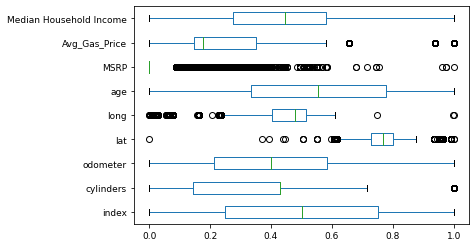

In [460]:
boxplot = df3.boxplot(grid=False, vert=False,fontsize=9)

In [461]:
from sklearn.linear_model import Ridge
#ridge = Ridge(solver='svd')
#ridge1 = Ridge(solver='svd')  
    

ridge = Ridge(solver='lsqr') #fastest solver for Ridge Regression
ridge1 = Ridge(solver='lsqr') #fastest solver for Ridge Regression 
    
    
#Instantiate and fit a ridge reg to the min_max scaled data
ridge_scaled = ridge.fit(X_train_mm, y_train)


# Instantiate and fit ridge reg classifier to the unscaled data
ridge_unscaled = ridge1.fit(X_train, y_train)


# Compute and print metrics
print('Accuracy with Min Max Scaling: {}'.format(ridge_scaled.score(X_val_mm, y_val)))
print('Accuracy without Scaling: {}'.format(ridge_unscaled.score(X_val, y_val)))


Accuracy with Min Max Scaling: 0.7092627999510107
Accuracy without Scaling: 0.2527953157285182


## Testing Models

## Comparison of the models:

We tested 6 different regression models 
* Linear
* Linear Log
* Ridge
* Ridge with PCA
* Linear with PCA
* elasticnet with PCA

We Test with Two parameterrs
* MAE
* RMSLE (Root Mean Squared Log Error)

Our dealer is using our prediction to decide if the asking price is lower than the predicted price he could get on Craig's list. The dealer is risk averse he does not want to take the deal if there is a high chance that the predicted price he is using is larger than the actual price. Therefore between two equally accurate models he would prefer if the  predictions under valued the car then over valued the car.

The RMSLE creates a larger penalty if the prediction is under the value than if it is over the value. Second RMSLe if we are looking at something with a long y tail distribution. This is seen in car prices. That said RMSLE usually also looks at something with exponent growth which is not the case here. We will use this as a first measurement of fit.


The Median Absolute Error is useful for just getting an overall fit of the model.It is a quick and easy way to compare how well one model does versus the other. Further it is not effected by the number of parameters as say R squared. This will give us the close prediction that we want. We will use this as our second measurement of fit.

Note for RMSLE we are looking at the lowest number not the highest.

#### Base testing Creating RMSLE 

We are going to put some restraints on the prediction. We know that the minimum price of the car is 0. So when we take the regressions we will zero out and predictions greater than 0.

In [472]:

def quick_run(estimatorx, X_train, y_train, X_test, y_test, folds=5, name_g= 'default'):
    """
    Put in X and Y train and test values as well as the regression
    ___
    Returns:  Y_ predictions and cross validated statistics
    """
    from sklearn.metrics import make_scorer, r2_score, median_absolute_error
    from sklearn.model_selection import cross_val_score
    #make rmsle score
    def rmsle(real, predicted):
        predicted[predicted<0] = 0
        return np.mean(np.square(np.log1p(real) - np.log1p(predicted)))    
    def MedianAbsoluteError(real:np.ndarray, predicted:np.ndarray) -> np.float64:
        """
        The Root Mean Squared Log Error (RMSLE) metric 
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
        """
        predicted[predicted<0] = 0
        return np.sqrt(median_absolute_error(real, predicted))

    rmsle_score = make_scorer(rmsle, greater_is_better=False)
    mae = make_scorer(MedianAbsoluteError, greater_is_better=False)
    #fit estimate
    estimatorx.fit(X_train, y_train)
        
    # Predict using model:
    y_predict= estimatorx.predict(X_train)
    y_predict_test = estimatorx.predict(X_test)
    y_predict[y_predict<0] = 0 #The minimum price for a car is 0
    y_predict_test[y_predict_test<0] = 0 #The minimum price for a car is 0   
    
    #Cross validate scores for rmsle
    #cv_scores_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=rmsle_score)
    #cv_scores_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=rmsle_score)
    
    cv_scores_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=rmsle_score)
    cv_scores_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=rmsle_score)
    
    #Cross validate scores for R2
    cv_mae_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=mae)
    cv_mae_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=mae)
    
    #get stats for cross validated scored rmsle
    
    cv_scores_test_mean= cv_scores_test.mean()
    cv_scores_train_mean= cv_scores_train.mean()
    cv_scores_test_std= cv_scores_test.std()
    
    #get stats for cross validated scored rmsle
    cv_mae_test_mean= cv_mae_test.mean()
    cv_mae_test_std= cv_mae_test.std()
    cv_mae_train_mean= cv_mae_train.mean()
    if name_g == 'default':
        name_reg = str(estimatorx)
    else:
        name_reg = name_g
    c= [name_reg,cv_mae_train_mean,  cv_mae_test_mean, cv_mae_test_std, cv_scores_train_mean, cv_scores_test_mean, cv_scores_test_std]
    

    print('Cross Validated Scores for regression equation: {} '.format(name_reg))
    print('RMSLE: ')
    print ('Mean train score: ' +str(cv_scores_train_mean))
    print ('Mean test score: ' +str(cv_scores_test_mean))
    print ('Standard Deviation test score: ' +str(cv_scores_test_std))
    print('')
    print('Negative Median Absolute Error: ')
    print ('Mean train score: ' +str(cv_mae_train_mean))
    print ('Mean test score: ' +str(cv_mae_test_mean))
    print ('Standard Deviation test score: ' +str(cv_mae_test_std))
    print('')
    diff = y_predict_test- y_test
    diff.hist(bins = 40)
    plt.title('Histogram of Error for {} '.format(name_reg))
    plt.xlabel('Error in Price Prediction')
    plt.ylabel('Frequency')
    return y_predict_test, c



#### Base testing 1 - Linear

Cross Validated Scores for regression equation: Linear 
RMSLE: 
Mean train score: -0.9027800329751301
Mean test score: -0.932255861267409
Standard Deviation test score: 0.11459547931430787

Negative Median Absolute Error: 
Mean train score: -48.82513204353845
Mean test score: -49.4519262760159
Standard Deviation test score: 0.6666990261647011



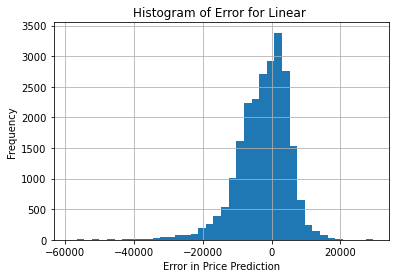

In [473]:
# Apply Linear model to training data:
linear = LinearRegression() 
y_predict_test_linear, c_linear = quick_run(linear, X_train, y_train, X_val_mm, y_val, name_g= 'Linear')

#### Base testing 2 - Linear_Log

Cross Validated Scores for regression equation: Linear Log 
RMSLE: 
Mean train score: -0.0035588683512425717
Mean test score: -0.003530513201391005
Standard Deviation test score: 0.00024057537003983578

Negative Median Absolute Error: 
Mean train score: -0.41417667932097524
Mean test score: -0.41824760339301675
Standard Deviation test score: 0.0033115055006499913



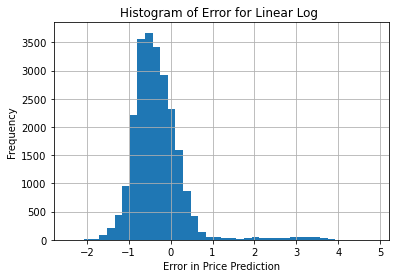

In [474]:
# Apply Linear Log model to training data:
linlog = LinearRegression() #previous optimization different study
y_train_lg = np.log(y_train)
y_val_lg = np.log(y_val)
y_predict_test_linlog, c_linlog = quick_run(linlog, X_train, y_train_lg, X_val_mm, y_val_lg, name_g ='Linear Log')


#### Base testing 3 - Ridge

Cross Validated Scores for regression equation: Ridge 
RMSLE: 
Mean train score: -0.4897947878447342
Mean test score: -0.9308827198592237
Standard Deviation test score: 0.1126013581898865

Negative Median Absolute Error: 
Mean train score: -70.9328424054175
Mean test score: -49.45617990934977
Standard Deviation test score: 0.6014504005236043



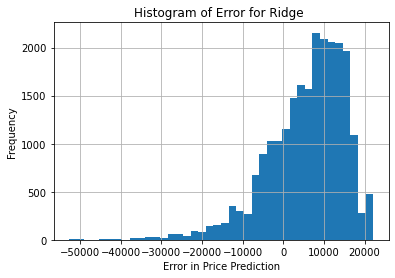

In [475]:
# Apply Ridge model to training data:
ridge_s = Ridge(solver=  'lsqr') #We specify solver because otherwise the program decides whichever solver it deems best
y_predict_test_ridge, c_ridge = quick_run(ridge_s, X_train, y_train, X_val_mm, y_val, name_g= 'Ridge')



#### Base testing 4 - Elasticnet

Cross Validated Scores for regression equation: ElasticNet 
RMSLE: 
Mean train score: -0.4611033884597534
Mean test score: -0.448079470064064
Standard Deviation test score: 0.020117631703649958

Negative Median Absolute Error: 
Mean train score: -51.3364435573248
Mean test score: -66.65941278094814
Standard Deviation test score: 0.3361033383883277



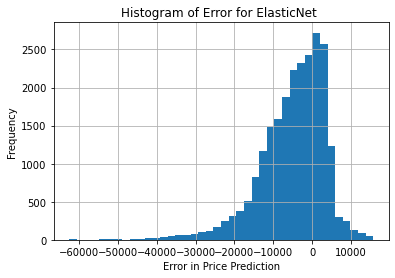

In [476]:
elastic = ElasticNet( selection= 'random'  ) #random was selected as the selector since it is faster
y_predict_test_elastic, c_elastic = quick_run(elastic, X_train, y_train, X_val_mm, y_val,  name_g= 'ElasticNet')


#### Base testing 5 - Linear PCA

Cross Validated Scores for regression equation: PCA Linear 
RMSLE: 
Mean train score: -0.5038409265623894
Mean test score: -0.4538315854074787
Standard Deviation test score: 0.01859515702709868

Negative Median Absolute Error: 
Mean train score: -71.46364658144839
Mean test score: -66.3215404156238
Standard Deviation test score: 0.20684351958068575



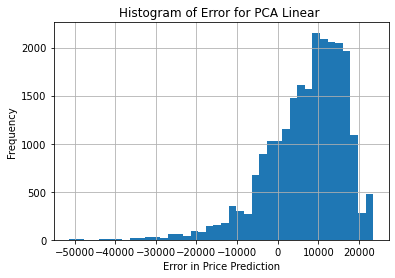

In [477]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=3) #from previous opt
# set the tolerance to a large value to make the example faster
linearz = LinearRegression()
pc_lin = Pipeline(steps=[('pca', pca), ('linear', linearz)])

y_predict_test_pca_lin, c_pca_lin = quick_run(pc_lin, X_train, y_train, X_val_mm, y_val, name_g= 'PCA Linear')


#### Base testing 6 - Ridge PCA

Cross Validated Scores for regression equation: PCA Ridge 
RMSLE: 
Mean train score: -0.5038409265623892
Mean test score: -0.45380600346870387
Standard Deviation test score: 0.018594837886522123

Negative Median Absolute Error: 
Mean train score: -71.4636465814489
Mean test score: -66.31521953389263
Standard Deviation test score: 0.2176123186047406



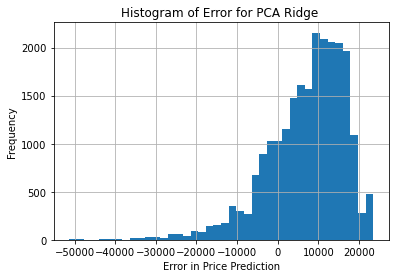

In [478]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=3) #from previous opt
# set the tolerance to a large value to make the example faster
ridge_p =  Ridge(solver='lsqr') #fastest solver for ridge
pc_ridge = Pipeline(steps=[('pca', pca), ('ridge', ridge_p)])

y_predict_test_pca_ridge, c_pca_ridge = quick_run(pc_ridge, X_train, y_train, X_val_mm, y_val, name_g= 'PCA Ridge')



#### Base testing 7 - Elasticnet PCA

Cross Validated Scores for regression equation: PCA Elastic 
RMSLE: 
Mean train score: -0.5038409265623893
Mean test score: -0.4538099724407877
Standard Deviation test score: 0.018552242978391847

Negative Median Absolute Error: 
Mean train score: -71.46364658144894
Mean test score: -66.30532167423283
Standard Deviation test score: 0.20095163552879408



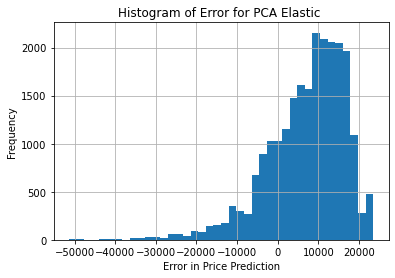

In [479]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=3) #from previous opt
# set the tolerance to a large value to make the example faster
elastic_p =  ElasticNet( selection= 'random' )  #fastest selection for elastic

pc_elastic = Pipeline(steps=[('pca', pca), ('elastic_p', elastic_p)])

y_predict_test_pca_elastic, c_pca_elastic = quick_run(pc_ridge, X_train, y_train, X_val_mm, y_val, name_g= 'PCA Elastic')


### Comparing Models

As we look at the 6 models we find a two trends:
* Ridge Regression and Ridge Regression with PCA have a higher RMSLE than the other regressions
* Regressions with PCA with the same components have identical values for RMSLE and MAE

This leaves us looking at Ridge Regression with PCA as the model we want to hypertune the parameters for.
We will also check if the model will look better with more or less features.





#### Comparing Models table

In [ ]:
score_columns= ['Algorithm', 'MAE Train', 'MAE Test',  'MAE Test std', 'RMSLE Train', 'RMSLE Test',  'RMSLE Test std']
c_data =[c_linear, c_ridge, c_elastic, c_pca_lin, c_pca_ridge, c_pca_elastic]
convert_dict = {'MAE Train': int, 'MAE Test': int} 
score_tab = pd.DataFrame(c_data, columns= score_columns )
score_tab = score_tab.astype(convert_dict) 

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
score_tab.sort_values('RMSLE Test', ascending= False)

#### Comparing Models Graph

In [ ]:
from matplotlib import cm
score_tab_RMSLE= score_tab[['Algorithm','RMSLE Train', 'RMSLE Test']].set_index('Algorithm')
cmap = cm.get_cmap('Spectral') 

ax=score_tab_RMSLE.plot.bar(rot=0, figsize=(10,6), cmap=cmap )
ax.tick_params(labelbottom=False,labeltop=True)
plt.title('Comparison of Algorithms on RMSLE score', fontsize=12)
plt.xlabel('Models',fontsize=10)
plt.ylabel ('RMSLE scores',fontsize=10)
plt.savefig("Figx_ModelComparison.png")


In [ ]:
from matplotlib import cm
score_tab_RMSLE= score_tab[['Algorithm','MAE Train', 'MAE Test']].set_index('Algorithm')
cmap = cm.get_cmap('tab10') 

ax=score_tab_RMSLE.plot.bar(rot=0, figsize=(10,6), cmap=cmap )
ax.tick_params(labelbottom=False,labeltop=True)
plt.title('Comparison of Algorithms on MAE score', fontsize=12)
plt.xlabel('Models',fontsize=10)
plt.ylabel ('RMSLE scores',fontsize=10)
plt.savefig("Figx_ModelComparison.png")


#### Notes
The  $R^{2}$ scores are very close between the models. Therefore we pick the one with the lowest standard deviation between $R^{2}$ scores which is the Ridge regression.

### Optimizing Ridge Regression

Now that we know that Ridge Regression (with and without PCA) looks like the best model we use a grid search to find the best parameters

### Applying Grid search CV for hyperparameter Tuning:

#### Hyperparameter Tuning: Ridge Regression

In [ ]:
#as I cannot use RMSLE to Grid searchI do that on my own. I don't cr

In [ ]:
# Testing different Ridge Regressions
params_Ridge = {'alpha': [1, 0.1, 0.001],  "fit_intercept": [True, False], 'solver': ['svd', 'lsqr', 'cholesky']}
ridge_reg = Ridge()



Ridge_GS = GridSearchCV(ridge_reg, param_grid=params_Ridge, cv=5, verbose=8)

Ridge_GS.fit(X_train_mm, y_train)
print('For non scaled data using Ridge Regression')
print('Best Score: {}'.format(Ridge_GS.best_score_))
print('Best estimator: {}'.format(Ridge_GS.best_estimator_))
print('Best parameters: {}'.format(Ridge_GS.best_params_))


Using the best parameters from the grid search we create the best ridge model

In [ ]:
print('For hyper parameter tuned Ridge Regression')
print('Best Score: {}'.format(Ridge_GS.best_score_))
print('Best estimator: {}'.format(Ridge_GS.best_estimator_))
print('Best parameters: {}'.format(Ridge_GS.best_params_))
#Ridge(alpha=0.1, solver='svd')


In [ ]:
Ridge_opt = Ridge(**Ridge_GS.best_params_)

from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=Ridge_opt, X=X_train_mm, y=y_train, cv=7)
print(all_accuracies)

Ridge_opt.fit(X_train_mm, y_train)


y_predict_Ridge_opt=Ridge_opt.predict(X_val_mm)
y_predict_Ridge_opt[y_predict_Ridge_opt<0] = 0
ridge_opt_score= Ridge_opt.score(X_val_mm, y_val)

print('Ridge using outside test_data : {}'.format(ridge_opt_score))

cv_scores_train = cross_val_score(estimator= Ridge_opt, X=X_train_mm, y=y_train, cv=5)

#we are going to use a larger set now to test
cv_scores_test = cross_val_score(estimator= Ridge_opt, X=X_test_mm, y=y_test, cv=5)
print(cv_scores_test)

RMSLE_Ridge_opt= mean_squared_log_error(y_predict_Ridge_opt, y_val)


cv_scores_ridge_opt_test= cv_scores_test.mean()
cv_scores_ridge_opt_train= cv_scores_train.mean()
cv_scores_ridge_opt_std= cv_scores_test.std()
print('For Ridge Regression:')
print ('Mean cross validation test score: ' +str(cv_scores_ridge_opt_test))
print ('Mean cross validation train score: ' +str(cv_scores_ridge_opt_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_ridge_opt_std))
print ('RMSLE: ' +str(RMSLE_Ridge_opt))

### Looking at the error for Optimized Ridge Regression

In [ ]:
diff = y_val- y_predict_Ridge_opt
awd = X_val['drive_4wd']
cylinders = X_val['cylinders']
Tesla = X_val['manufacturer_Tesla']
electric = X_val['fuel_electric']==1

gas = X_val['fuel_gas']==1
sns.histplot(x=diff, binrange=[-30000, 30000], hue= gas)
plt.title('Histogram of Errr for Ridge Regression with hyper tuned Parameters')
plt.xlabel('Price Prediction Error $')

plt.xlabel('Difference in Price')


In [ ]:
p= sns.jointplot(x=y_val, y=y_predict_Ridge_opt, kind="kde", xlim= [4000, 70000], hue= gas )
p.fig.suptitle("Scatterplot of Ridge regression with PCA  Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


### Calculating Coefficents and it's importance

In [ ]:

#Table and features
feature_names = X_train.columns

coefs = pd.DataFrame(
    Ridge_opt.coef_,
    columns=['Coefficients'], index=feature_names
)


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    Ridge_opt, X_train_mm, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True
)

coefs2 = pd.DataFrame(
    [est.coef_  for est in cv_model['estimator']],
    columns=feature_names
)

fig, axs = plt.subplots(1, 2, figsize=(14, 24), sharey=True, sharex=True)


ax = plt.subplot(121)
sns.barplot(x='Coefficients', y=feature_names, data=coefs)
plt.title("Coefficents value")

plt.subplot(122)
#graphing coefficent and importance
#sns.swarmplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.stripplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=coefs2, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title("Coefficents variability")
plt.xlabel('Coefficient importance')

plt.subplots_adjust(left=.3)

for ax in fig.get_axes():
    ax.label_outer()
#fig.title('Ridge model no PCA Coefficents')

In [ ]:
### Ridge PCA chained

#we are going to use the best parameters from the previous search and see


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
#ridge = Ridge(solver='lsqr')
pipe = Pipeline(steps=[('pca', pca), ('ridge', ridge)])

#we use the best solver from the previous regression

param_grid = {
    'pca__n_components': [3, 5, 7, 10, 15, 30, 60, 85, 90],
    'ridge__alpha': [1, 0.1, 0.001],
    'ridge__solver': [Ridge_GS.best_estimator_.solver]
}
search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose= 8)
search.fit(X_train, y_train)

print('For Min Max scaled data using chained PCA and Ridge  Regression')
print('Best Score: {}'.format(search.best_score_))
print('Best estimator: {}'.format(search.best_estimator_))
print('Best parameters: {}'.format(search.best_params_))


In [ ]:

pipe_p = search.best_estimator_


from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=pipe_p, X=X_train_mm, y=y_train, cv=7)
print(all_accuracies)

pipe_p.fit(X_train_mm, y_train)


y_predict_Ridge_opt_pca=pipe_p.predict(X_val_mm)
y_predict_Ridge_opt_pca[y_predict_Ridge_opt_pca<0] = 0
Ridge_opt_pca_score= pipe_p.score(X_val_mm, y_val)

print('Ridge using outside test_data : {}'.format(Ridge_opt_pca_score))

cv_scores_train = cross_val_score(estimator= pipe_p, X=X_train_mm, y=y_train, cv=5)

#we are going to use a larger set now to test
cv_scores_test = cross_val_score(estimator= pipe_p, X=X_test_mm, y=y_test, cv=5)
print(cv_scores_test)

RMSLE_Ridge_opt_pca= mean_squared_log_error(y_predict_Ridge_opt_pca, y_val)


cv_scores_ridge_opt_pca_test= cv_scores_test.mean()
cv_scores_ridge_opt_pca_train= cv_scores_train.mean()
cv_scores_ridge_opt_pca_std= cv_scores_test.std()
print('For Optimized Ridge Regression with PCA:')
print ('Mean cross validation test score: ' +str(cv_scores_ridge_opt_pca_test))
print ('Mean cross validation train score: ' +str(cv_scores_ridge_opt_pca_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_ridge_opt_pca_std))
print ('RMSLE: ' +str(RMSLE_Ridge_opt_pca))

We graph the predictions using an optimized Ridge Regression vs the actuals

### Looking at the error for Optimized Ridge with PCA

In [ ]:
diff_pca = y_val- y_predict_Ridge_opt_pca
awd = X_val['drive_4wd']
cylinders = X_val['cylinders']
Tesla = X_val['manufacturer_Tesla']
electric = X_val['fuel_electric']==1

gas = X_val['fuel_gas']==1
sns.histplot(x=diff, binrange=[-30000, 30000], hue= gas)
plt.title('Histogram of Error for Optimized Ridge Regression with PCA')
plt.xlabel('Price Prediction Error $')

plt.xlabel('Difference in Price')


In [ ]:
p= sns.jointplot(x=y_val, y=y_predict_Ridge_opt_pca, kind="kde", xlim= [4000, 70000], hue= gas )
p.fig.suptitle("Scatterplot of Ridge regression with PCA  Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


### Calculating Coefficents and it's importance

Next we determine which features have an actual importance. Since we used PCA we find out how much each additional compent helped to explain the data.
We note that it is the first by the time we get to PCA n_components=10 we have explained most of the data

In [ ]:
# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 90)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import median_absolute_error

y_pred = Ridge_opt.predict(X_train_mm)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: $ {mae:.2f} '
y_pred = Ridge_opt.predict(X_val_mm)
mae = median_absolute_error(y_val, y_pred)
string_score += f'\nMAE on testing set: $ {mae:.2f} '
plt.scatter(y_val, y_pred)
#ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
#plt.text(-2, 0, string_score)
plt.title('Ridge model, Hypertuned parameters')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([9000, 7000])
plt.ylim([9000, 7000])
print(string_score)

Compare Models

In [ ]:
# stop when you get here

Whe we compare the models there is not much difference between the train scores. However the Ridge non optimized has  lower test score when we look at the standard deviation we can see that it already showed a higher standard deviation

First let us get an idea what these model look like 

In [ ]:
search.best_params_

In [ ]:
myLabels_r = [ 'Ridge', 'Ridge with PCA', 'Ridge Optimized', 'Ridge Optimized with PCA']
solver_r = [ridge_s.solver,ridge_p.solver, Ridge_opt.solver, search.best_params_['ridge__solver']]
alpha_r = [ridge_s.alpha,ridge_p.alpha, Ridge_opt.alpha, search.best_params_['ridge__alpha']]

 
pca_r = [False , True, False, True]
n_components_r = ['NA', '85', 'NA', search.best_params_['pca__n_components']]

RMSLE_r = [RMSLE_ridge, RMSLE_pc_ridge, RMSLE_Ridge_opt, RMSLE_Ridge_opt_pca]
score_test_r= [cv_scores_ridge_test, cv_scores_pc_ridge_test, cv_scores_ridge_opt_test, cv_scores_ridge_opt_pca_test]
score_train_r= [cv_scores_ridge_train, cv_scores_pc_ridge_train, cv_scores_ridge_opt_train, cv_scores_ridge_opt_pca_train]
score_std_r= [cv_scores_ridge_std, cv_scores_pc_ridge_std, cv_scores_ridge_opt_std, cv_scores_ridge_opt_pca_std]
            
score_tab_r = pd.DataFrame(list(zip(myLabels_r, RMSLE_r, score_train_r, score_test_r, score_std_r)), 
               columns =['Algorithm', 'RMSLE','R2 train score', 'R2 test score', 'R2 deviation train score' ])


equation_tab_r = pd.DataFrame(list(zip(myLabels_r, solver_r, alpha_r,pca_r, n_components_r)), 
columns =['Algorithm', 'Solver', 'Alpha', 'Has PCA', 'PCA components'])

equation_tab_r

In [ ]:
score_tab_r

### Choosing the Model aka Concusion
Now we check on how the results of these algorithm compare. Both optimized regressions have a betteer score than the non optimized regression. 

We therefore go with the model that is simpler aka the Ridge without PCA. The data has been less processed and the factors are easier to explain.


In [ ]:
#Forecast for the price of the Tesla 

In [ ]:
#Future Studies

In [ ]:
#Write conclusgion
    #Future steps
    #Scrape MSRP for all vehicles
    # do an f regression to further limit factors
    #Multiple years of data
    #actual selling price